# Visualisation of the trajectories

*Warning*: The visualisation of a big trajectory files may take some long minutes. So, patience! 

Usage: 
```
Run --> Run All Cells
```

The name of the geometry anmd trajectory files are automatically extracted from the inifile. 
Moreover, the value of frames per seconds (*fps*) is also extracted from the inifile


Therefore, ou may change the value of the inifile in the following cell before running the cells.

In [95]:
inifile = "ini_jpscore.xml"

In [102]:
%%capture
import sys
shared_path = 'libs'
if shared_path not in sys.path:
    sys.path.append(shared_path)
    
%run libs/vislib
%run libs/imports

In [99]:
%%capture
d = parse(inifile)
traj_filename = os.path.join('results', d.getElementsByTagName('file')[0].attributes.items()[0][1])
geo_filename= os.path.join('results', d.getElementsByTagName('geometry')[0].firstChild.nodeValue)
fps = int(d.getElementsByTagName('trajectories')[0].attributes.items()[1][1])

print("geo: ", geo_filename)
print("traj: ", traj_filename)
print("fps: ", fps)

#######

xml_datei = open(geo_filename, "r")
geo_xml = parse(xml_datei)
xml_datei.close()

geometry_wall = read_subroom_walls(geo_xml)

geometry_obst = read_obstacle(geo_xml)

df_traj = pd.read_csv('{}'.format(traj_filename),
                      comment='#',
                      sep='\s+',
                      names=['ID', 'FR', 'X', 'Y', 'Z', 'A', 'B', 'ANGLE', 'COLOR'],
                      index_col=False)

df_traj['Z'] = df_traj['Z'] / 1000

# sort the dataframe
df_traj.sort_values(by=['FR'])
# set the index to be this and don't drop
df_traj.set_index(keys=['FR'], drop=False, inplace=True)
# get a list of names
frames = df_traj['FR'].unique().tolist()

fig, ax = plt.subplots()
df_0 = df_traj.loc[df_traj.FR == 0]
x, y = [df_0.X], [df_0.Y]
# colors = np.random.rand(len(df_0.V))
sc = ax.scatter(df_0.X, df_0.Y, c=df_0.COLOR, vmin=0, vmax=255, cmap=plt.cm.get_cmap('RdYlBu'))
plt.axis('off')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
fig.colorbar(sc, ax=ax, cax=axins)


def init():
    ax.set_aspect('equal')
    for g in geometry_obst.keys():
        ax.add_patch(ppolygon(geometry_obst[g], color='gray'))

    for gw in geometry_wall.keys():
        ax.plot(geometry_wall[gw][:, 0], geometry_wall[gw][:, 1], color='black', lw=2)

    return ax,


def update(frame):
    plt.title('Frame {0:6.0f}'.format(frame))
    df_frame = df_traj.loc[df_traj.FR == frame]
    df_frame.sort_values(by=['ID'])

    sc.set_offsets(np.c_[df_frame.X, df_frame.Y])
    sc.set_array(df_frame.COLOR)

    return sc


ani = FuncAnimation(fig, update, init_func=init, blit=False, frames=df_traj['FR'].max())


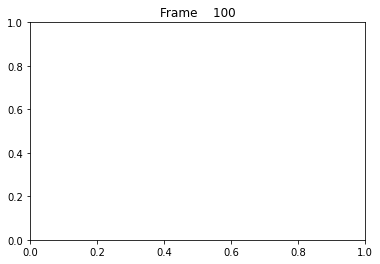

In [100]:
HTML(ani.to_html5_video())

In [ ]:
print('Frame  - min: {0:6.0f} - max: {1:6.0f}'.format(df_traj['FR'].min(), df_traj['FR'].max()))
print('PersID - min: {0:6.0f} - max: {1:6.0f}'.format(df_traj['ID'].min(), df_traj['ID'].max()))
print('Xmin: {0:6.2f} m - Xmax: {1:6.2f} m'.format(df_traj['X'].min(), df_traj['X'].max()))
print('Ymin: {0:6.2f} m - Ymax: {1:6.2f} m'.format(df_traj['Y'].min(), df_traj['Y'].max()))
print('Zmin: {0:6.2f} m - Zmax: {1:6.2f} m'.format(df_traj['Z'].min(), df_traj['Z'].max()))
